# 8. Gyakorlat: Objektum Detekció
## Könyvtárak

In [1]:
import os
import warnings
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib as mpl
from zipfile import ZipFile
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import matplotlib.patches as patches

import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.ops import box_iou
from torchvision.models import detection
from torch.utils.data import DataLoader, Dataset
from torch.utils.data._utils.collate import default_collate

warnings.filterwarnings('ignore')

## Adathalmaz
### Letöltés

In [2]:
url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip'  # Link az adatokhoz
response = requests.get(url)  # HTTP kérés intézése 

if response.status_code == 200:
    zip_content = BytesIO(response.content)  # Adatok letöltése
    with ZipFile(zip_content, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Sikeres letöltés")
else:
    print("Az adatok letöltése sikertelen volt:", response.status_code)

Sikeres letöltés


### Tisztítás

In [3]:
images_dir = './coco128/images/train2017/'
labels_dir = './coco128/labels/train2017/'


def remove_unpaired_datapoints(src_dir, dst_dir):
    for src_name in os.listdir(src_dir):
        src_file = os.path.join(src_dir, src_name)
        src_filename = os.path.splitext(os.path.basename(src_file))[0]
        flag = False
        for dst_name in os.listdir(dst_dir):
            dst_file = os.path.join(dst_dir, dst_name)
            dst_filename = os.path.splitext(os.path.basename(dst_file))[0]
            if dst_filename == src_filename:
                flag = True
        if not flag:
            os.remove(src_file)
            print(f'Removed: {src_file}')


remove_unpaired_datapoints(images_dir, labels_dir)
remove_unpaired_datapoints(labels_dir, images_dir)

# Sanity check
for x, y in list(zip(sorted(os.listdir('./coco128/images/train2017')), sorted(os.listdir('./coco128/labels/train2017')))):
    x = x.split('.')[0]
    y = y.split('.')[0]
    if x != y:
        print(f'Unpaired datapoint: {x}, {y}')

Removed: ./coco128/images/train2017/000000000508.jpg
Removed: ./coco128/images/train2017/000000000250.jpg
Removed: ./coco128/labels/train2017/000000000656.txt
Removed: ./coco128/labels/train2017/000000000659.txt


## Modellek betöltése

In [4]:
ssd300 = detection.ssd300_vgg16(pretrained=True)  # SSD 
retinanet = detection.retinanet_resnet50_fpn(pretrained=True)  # RetinaNet
faster_rcnn = detection.fasterrcnn_resnet50_fpn(pretrained=True)  # Faster-RCNN

# Modellek kiértékelő üzemmódba kapcsolása
ssd300.eval()
retinanet.eval()
faster_rcnn.eval()

models = [ssd300, retinanet, faster_rcnn]

## Adatbetöltő létrehozása

./coco128/images/train2017/000000000151.jpg ./coco128/labels/train2017/000000000151.txt
./coco128/images/train2017/000000000143.jpg ./coco128/labels/train2017/000000000143.txt
./coco128/images/train2017/000000000061.jpg ./coco128/labels/train2017/000000000061.txt
./coco128/images/train2017/000000000562.jpg ./coco128/labels/train2017/000000000562.txt


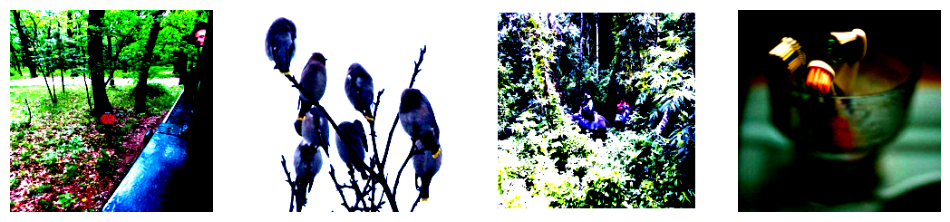

In [5]:
class COCO128Dataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_size = (224, 224)
        self.images_dir = os.path.join(self.root_dir, 'images/train2017')
        self.labels_dir = os.path.join(self.root_dir, 'labels/train2017')
        self.images = sorted(os.listdir(self.images_dir))
        self.labels = sorted(os.listdir(self.labels_dir))
        
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),  # Kép átméretezése
            transforms.ToTensor(),  # Képek átalakítása pytorch tenzorokká
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizálás
        ])


    def __len__(self):
        return len(self.images)

    def load_labels(self, label_path, original_size):
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                scale_x = self.image_size[0] / original_size[0]
                scale_y = self.image_size[1] / original_size[1]
                for line in file:
                    class_id, cx, cy, w, h = map(float, line.split())
                    cx *= scale_x
                    cy *= scale_y
                    w *= scale_x
                    h *= scale_y
                    labels.append((class_id, cx, cy, w, h))
        return labels

    def __getitem__(self, idx):
        image_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(image_name).convert('RGB')  # Kép megnyitása
        image_size = image.size
        image = self.transform(image)  # Transzformációk alkalmazása a képen
        labels_name = os.path.join(self.labels_dir, self.images[idx].replace('.jpg', '.txt'))
        labels = self.load_labels(labels_name, image_size)
        return image, labels


def custom_collate(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    images = default_collate(images)
    return images, labels


def plot_images(dataloader):
    images, labels = next(iter(dataloader))  # Egy képköteg lekérdezése
    plt.figure(figsize=(12, 8))
    for i, image in enumerate(images):
        image = np.clip(image, 0, 1)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Dimenziók átrendezése átrendezése BGR -> RGB
        plt.axis('off')
    plt.show()


# Adatbetöltő létrehozása és kipróblálása
data_dir = './coco128'
coco_dataset = COCO128Dataset(data_dir)
dataloader = DataLoader(coco_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
plot_images(dataloader)

## Modellek futtatása az adatokon
### Predikció

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_predictions = {model.__class__.__name__: [] for model in models}  # Dictionaries to hold predictions for each model

for model in models:  # Move models to the appropriate device
    model.to(device)

for images, targets_list in dataloader:  # Iterate over the data loader
    images = list(image.to(device) for image in images)

    # Convert targets_list (list of lists) to the expected format
    targets = []
    for target in targets_list:
        target_dict = {'boxes': [], 'labels': []}
        for label in target:
            if label:  # Assuming label is not empty and has the format (class_id, cx, cy, w, h)
                target_dict['boxes'].append(label[1:])  # Add bounding box coordinates
                target_dict['labels'].append(label[0])  # Add class ID
        # Convert lists to tensors
        target_dict['boxes'] = torch.tensor(target_dict['boxes']).to(device)
        target_dict['labels'] = torch.tensor(target_dict['labels']).to(device)
        targets.append(target_dict)

    with torch.no_grad():  # Run inference with each model
        for model in models:
            predictions = model(images)
            all_predictions[model.__class__.__name__].append((predictions, targets))

./coco128/images/train2017/000000000307.jpg ./coco128/labels/train2017/000000000307.txt
./coco128/images/train2017/000000000149.jpg ./coco128/labels/train2017/000000000149.txt
./coco128/images/train2017/000000000247.jpg ./coco128/labels/train2017/000000000247.txt
./coco128/images/train2017/000000000196.jpg ./coco128/labels/train2017/000000000196.txt
./coco128/images/train2017/000000000127.jpg ./coco128/labels/train2017/000000000127.txt
./coco128/images/train2017/000000000309.jpg ./coco128/labels/train2017/000000000309.txt
./coco128/images/train2017/000000000650.jpg ./coco128/labels/train2017/000000000650.txt
./coco128/images/train2017/000000000164.jpg ./coco128/labels/train2017/000000000164.txt
./coco128/images/train2017/000000000263.jpg ./coco128/labels/train2017/000000000263.txt
./coco128/images/train2017/000000000094.jpg ./coco128/labels/train2017/000000000094.txt
./coco128/images/train2017/000000000154.jpg ./coco128/labels/train2017/000000000154.txt
./coco128/images/train2017/00000

In [7]:
for model_name, data in all_predictions.items():
    true_positives, false_positives, false_negatives = 0, 0, 0
    for predictions, targets in data:
        for i in range(len(predictions)):
            true_boxes = targets[i]['boxes']
            pred_boxes = predictions[i]['boxes']

            if true_boxes.nelement() == 0 or pred_boxes.nelement() == 0 or true_boxes.ndim != 2 or pred_boxes.ndim != 2:
                continue

            iou = box_iou(pred_boxes, true_boxes)
            threshold = 0.5
            for j in range(len(pred_boxes)):
                if iou[j].max() > threshold:
                    true_positives += 1
                else:
                    false_positives += 1

            for j in range(len(true_boxes)):
                if iou[:, j].max() < threshold:
                    false_negatives += 1

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Model {model_name} - Precision: {precision}, Recall: {recall}")

Model SSD - Precision: 0.0, Recall: 0.0
Model RetinaNet - Precision: 0.0, Recall: 0.0
Model FasterRCNN - Precision: 0.0, Recall: 0.0
